# Ultimate Data Challenge Part 3: Predictive Modeling

Scott Atkinson

## [0. Contents](#0.)<a id='0.'></a>

## [1. Import libraries and data](#1.)

## [2. EDA](#2.)

## [3. Modeling](#3.)

* ### [3.1. Threshold tuning](#3.1.)
* ### [3.2. Feature importance](#3.2.)

## [4. Conclusion](#4.)

## 1. Import libraries and data<a id='1.'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report, fbeta_score, roc_curve, precision_recall_curve

plt.rcParams['figure.figsize'] = (10,10)

In [2]:
df = pd.read_json('ultimate_data_challenge.json')
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# set label variable for "churned" users
df['target'] = df['last_trip_date'] <= '2014-05-31'

df = df[['target','city','trips_in_first_30_days','signup_date','avg_rating_of_driver','avg_surge','last_trip_date','phone','surge_pct','ultimate_black_user','weekday_pct','avg_dist','avg_rating_by_driver']]
df['weekday_pct'] = df['weekday_pct']/100
df['avg_rating_of_driver'] = df['avg_rating_of_driver']/5
df['avg_rating_by_driver'] = df['avg_rating_by_driver']/5
df['surge_pct'] = df['surge_pct']/100

In [3]:
df.head()

,target,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,False,King's Landing,4,2014-01-25,0.94,1.10,2014-06-17,iPhone,0.154,True,0.462,3.67,1.00
1,True,Astapor,0,2014-01-29,1.00,1.00,2014-05-05,Android,0.000,False,0.500,8.26,1.00
2,True,Astapor,3,2014-01-06,0.86,1.00,2014-01-07,iPhone,0.000,False,1.000,0.77,1.00
3,False,King's Landing,9,2014-01-10,0.92,1.14,2014-06-29,iPhone,0.200,True,0.800,2.36,0.98
4,True,Winterfell,14,2014-01-27,0.88,1.19,2014-03-15,Android,0.118,False,0.824,3.13,0.98


In [4]:
df.isnull().sum()

target                       0
city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [5]:
# replace missing avg ratings of/by driver with mean
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())

# drop entries with missing phone values
df = df.dropna(subset=['phone'])

In [6]:
df.isnull().sum()

target                    0
city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [7]:
df[~df['target']].shape

(18671, 13)

In [8]:
df.shape

(49604, 13)

In [9]:
df[~df['target']].shape[0]/df.shape[0]

0.37640109668575117

Retained 18671 out of 49604 users for a percentage of 37.64%.

## 2. EDA<a id='2.'></a>

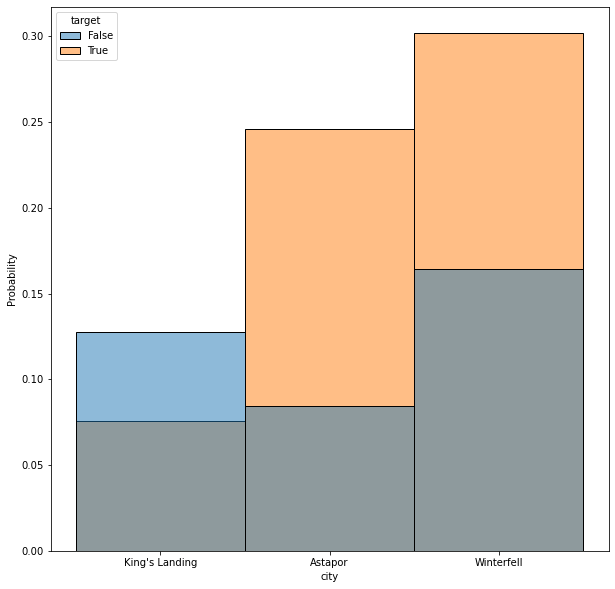

In [10]:
# histogram for city grouped by target
sns.histplot(data=df, x='city', hue='target', stat='probability')
plt.show()

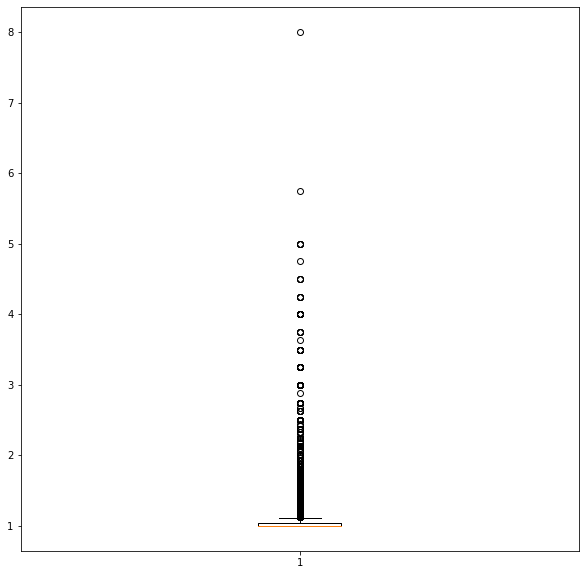

In [11]:
plt.boxplot(df['avg_surge'])
plt.show()

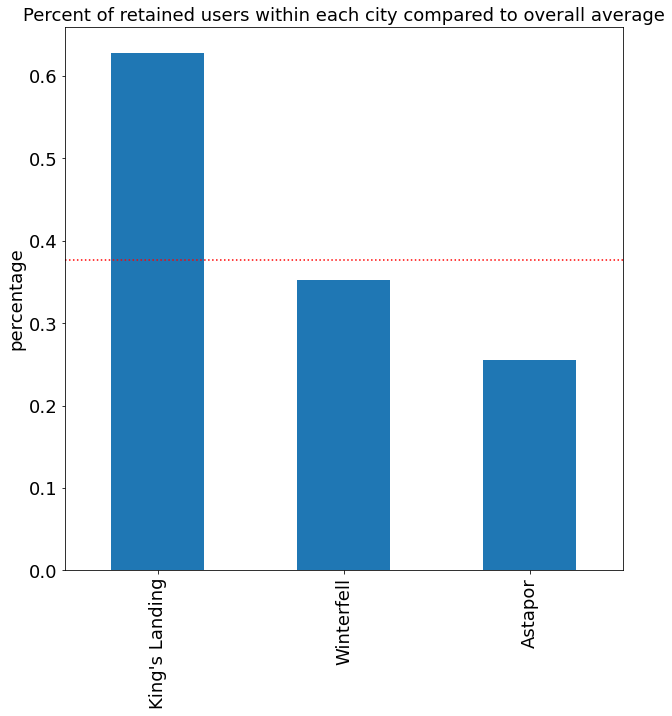

In [12]:
# percentage of retained users within each city compared to overall average

average_retained = df[~df['target']].shape[0]/df.shape[0]

def percentage(city):
    t = df[(df['target']==False)&(df['city']==city)].shape[0]
    total = df[df['city']==city].shape[0]
    return t/total

city_rate = {city:percentage(city) for city in ["King's Landing", 'Astapor','Winterfell']}
city_rate = dict(sorted(city_rate.items(), key=lambda item: item[1], reverse=True))

pd.DataFrame(city_rate, index = [0]).transpose().plot.bar(legend=None, fontsize=18)
plt.hlines(y = average_retained, color='r', xmin=-.5,xmax=2.5, ls='dotted')
plt.ylabel('percentage', fontsize=18)
plt.title('Percent of retained users within each city compared to overall average', fontsize=18)
plt.show()

In [13]:
print(average_retained)

0.37640109668575117


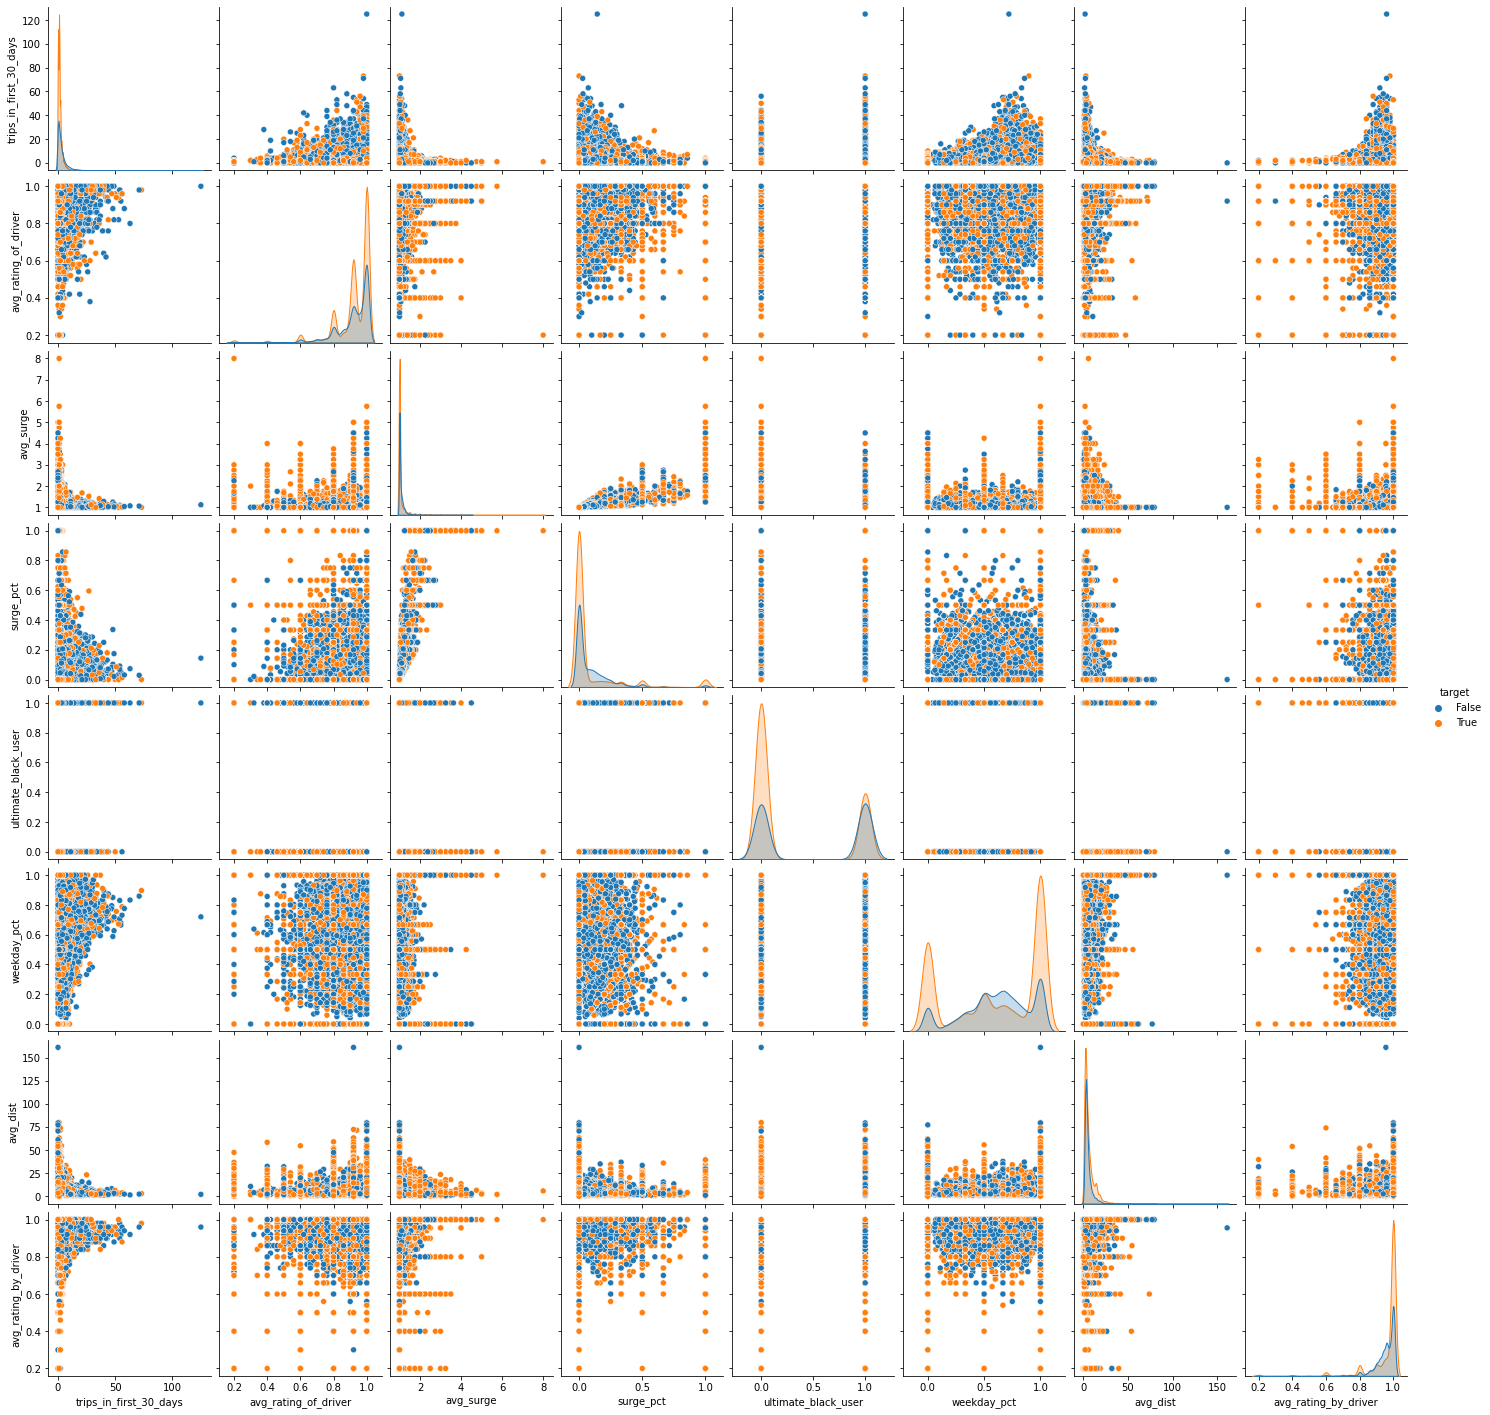

In [14]:
sns.pairplot(df, hue='target')
plt.show()

## 3. Modeling<a id='3.'></a>

In [15]:
# obtain train mask

itrain, itest = train_test_split(range(df.shape[0]), stratify=df['target'], test_size=0.2, random_state=2)
mask = np.zeros(df.shape[0], dtype=np.bool)
mask[itrain] = True

We scale the variables `trips_in_first_30_days`, `avg_dist`, and `avg_surge` so their magnitudes don't skew our models (we end up using decision tree ensembles mostly, so the scaling has no effect in the end).  We use `MinMaxScaler` on the first two variables because they have a clear minimum at 0.  We use `RobustScaler` on `avg_surge` because it has many outliers according to the boxplot above.

In [16]:
# scale trips_in_first_30_days and avg_dist

trips_scaler = MinMaxScaler()
dist_scaler = MinMaxScaler()
surge_scaler = RobustScaler()

trips_scaler.fit(np.array(df[mask]['trips_in_first_30_days']).reshape(-1,1))
dist_scaler.fit(np.array(df[mask]['avg_dist']).reshape(-1,1))
surge_scaler.fit(np.array(df[mask]['avg_surge']).reshape(-1,1))

df['trips_in_first_30_days'] = trips_scaler.transform(np.array(df['trips_in_first_30_days']).reshape(-1,1))
df['avg_dist'] = dist_scaler.transform(np.array(df['avg_dist']).reshape(-1,1))
df['avg_surge'] = surge_scaler.transform(np.array(df['avg_surge']).reshape(-1,1))

We pass the categorical variables to dummies so they can be incorporated into the model.

In [17]:
df = pd.get_dummies(df)

In [18]:
df.head()

,target,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,False,0.032,2014-01-25,0.94,2.0,2014-06-17,0.154,True,0.462,0.022801,1.00,0,1,0,0,1
1,True,0.000,2014-01-29,1.00,0.0,2014-05-05,0.000,False,0.500,0.051317,1.00,1,0,0,1,0
2,True,0.024,2014-01-06,0.86,0.0,2014-01-07,0.000,False,1.000,0.004784,1.00,1,0,0,0,1
3,False,0.072,2014-01-10,0.92,2.8,2014-06-29,0.200,True,0.800,0.014662,0.98,0,1,0,0,1
4,True,0.112,2014-01-27,0.88,3.8,2014-03-15,0.118,False,0.824,0.019446,0.98,0,0,1,1,0


In [19]:
X = df.drop(['target','signup_date','last_trip_date'], axis=1)
y = df['target']

X_train = X[mask]
X_test = X[~mask]

y_train = y[mask]
y_test = y[~mask]

In [20]:
# RandomizedSearchCV on random forest:

start = time.time()

steps = [('RF', RandomForestClassifier(random_state=2,n_jobs=3))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]

criteria = ['gini','entropy']

depths = [int(n) for n in np.logspace(start=1, stop=2, num = 20)]

num_features = ['auto','sqrt','log2']

RF_params = {'RF__n_estimators': n_est,\
             'RF__criterion':criteria, 'RF__max_depth':depths, 'RF__max_features':num_features}

RF_pipe = Pipeline(steps)

RF_cv = RandomizedSearchCV(RF_pipe, param_distributions=RF_params, scoring='roc_auc', cv=3, random_state=2)

RF_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)
             

RF_df = pd.DataFrame(RF_cv.cv_results_)
RF_df.to_csv('CV_results/RF_cv_results.csv')
RF_cv.best_score_

Time elapsed:  216.62535190582275


0.8496200243252051

In [21]:
RF_df.to_csv('CV_results/RF_cv_results.csv')
RF_cv.best_score_

0.8496200243252051

In [22]:
pred = RF_cv.best_estimator_.predict(X_test)
print(roc_auc_score(y_test,pred))

0.7571111880059517


In [23]:
# GridSearchCV LogisticRegression 


start = time.time()

steps = [('LogReg', LogisticRegression())]

penalties = ['l1', 'l2', 'elasticnet', 'none']

duals = [True, False]

tols = [0.0001,0.001,0.01,0.1]

Cs = [0.01,0.1,1,2]

LogReg_params = {'LogReg__penalty':penalties, 'LogReg__dual':duals, 'LogReg__tol':tols, 'LogReg__C':Cs}

LogReg_pipe = Pipeline(steps)

LogReg_cv = GridSearchCV(LogReg_pipe, param_grid=LogReg_params, scoring='roc_auc', cv=3)

LogReg_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)
             

LogReg_df = pd.DataFrame(LogReg_cv.cv_results_)
LogReg_df.to_csv('CV_results/LogReg_cv_results.csv')
LogReg_cv.best_score_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

Time elapsed:  35.18750786781311


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.760208138264293

In [24]:
pred = LogReg_cv.best_estimator_.predict(X_test)
print(roc_auc_score(y_test,pred))

0.6710954401080622


In [25]:
# RandomizedSearchCV on GradientBoostingClassifier:

start = time.time()

steps = [('gbc', GradientBoostingClassifier(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]

depths = [3,7,15]

lr = [0.01, 0.1, 1]

gbc_params = {'gbc__n_estimators': n_est, 'gbc__learning_rate':lr, 'gbc__max_depth':depths}

gbc_pipe = Pipeline(steps)

gbc_cv = RandomizedSearchCV(gbc_pipe, param_distributions=gbc_params, cv=5, scoring='roc_auc', random_state=2)

gbc_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)


gbc_df = pd.DataFrame(gbc_cv.cv_results_)
gbc_df.to_csv('gbc_cv_results.csv')
gbc_cv.best_score_

Time elapsed:  2412.809364080429


0.8534275355775721

In [26]:
pred = gbc_cv.best_estimator_.predict(X_test)
print(roc_auc_score(y_test,pred))

0.7648918127396898


In [27]:
# RandomizedSearchCV on AdaBoostClassifier:

start = time.time()

steps = [('ada', AdaBoostClassifier(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3.5, num=30)]



lr = [0.01, 0.1, 1]

ada_params = {'ada__n_estimators': n_est, 'ada__learning_rate':lr}

ada_pipe = Pipeline(steps)

ada_cv = RandomizedSearchCV(ada_pipe, param_distributions=ada_params, cv=5, scoring='roc_auc', random_state=2)

ada_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)


ada_df = pd.DataFrame(ada_cv.cv_results_)
ada_df.to_csv('ada_cv_results.csv')
ada_cv.best_score_

Time elapsed:  838.4555690288544


0.848537072229458

In [28]:
pred = ada_cv.best_estimator_.predict(X_test)
print(roc_auc_score(y_test,pred))

0.7569312705277553


### 3.1. Threshold tuning<a id='3.1.'></a>

In [29]:
def y_crisp(probs, threshold):
    return (probs >= threshold).astype('int')

In [30]:
def fbeta(pre, rec, beta=1):
    return (1+beta**2)*(pre*rec)/((beta**2)*pre + rec)

In [31]:
def results(clf):
    start = time.time()
    print('Threshold analysis for ', clf.__class__.__name__)
    yproba = clf.predict_proba(X_test)[:,1]
    
    # plot F scores against thresholds for beta = 0.5, 1, 2
    
    thresh = np.arange(0,1,0.001)
    extraticks = []
    for beta, color, color_plot in zip([0.5, 1, 2],['black','blue','red'], ['grey','green','pink']):
        scores = np.array([fbeta_score(y_test, y_crisp(yproba, t), beta=beta) for t in thresh])
        ix = np.argmax(scores)
        best_thresh = thresh[ix]
        print('Best threshold for F_%s: %s'%(beta,best_thresh))
        plt.plot(thresh,scores, c = color_plot, label='F%s scores'%beta)
        plt.axvline(x=best_thresh, label='Best threshold for F_%s'%(beta), c=color)
        
        
        
        extraticks.append(best_thresh)
    
    plt.title('%s F-scores'%(clf.__class__.__name__), fontsize=18)
    plt.legend(loc='upper right', fontsize=18)
    plt.xlabel('thresholds', fontsize=18)
    plt.ylabel('F scores', fontsize=18)
#     plt.xticks([0,0.2, 0.4, 0.6, 0.8, 1] + extraticks, fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
#     plt.savefig('Report/%s_F-scores.jpeg'%(clf.__class__.__name__))
    plt.show()
    
    # plot thresholds on precision-recall curve
    
    precision, recall, thresholds = precision_recall_curve(y_test, yproba)
    # convert to f score

    fhalfscore = fbeta(precision,recall,beta=0.5)
    f1score = fbeta(precision,recall)
    f2score = fbeta(precision,recall,beta=2)

    #fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ixhalf = np.nanargmax(fhalfscore)
    ix1 = np.nanargmax(f1score)
    ix2 = np.nanargmax(f2score)
    print('Best Threshold for F_0.5: %f, F_0.5-Score=%.3f' % (thresholds[ixhalf], fhalfscore[ixhalf]))
    print('Best Threshold for F_1: %f, F_1-Score=%.3f' % (thresholds[ix1], f1score[ix1]))
    print('Best Threshold for F_2: %f, F_2-Score=%.3f' % (thresholds[ix2], f2score[ix2]))

    # plot the precision-recall curve for the model
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='model')
    plt.plot(recall[ixhalf], precision[ixhalf], marker='o', color='black', label='Best F_0.5', markersize=10)
    plt.plot(recall[ix1], precision[ix1], marker='o', color='blue', label='Best F_1',markersize=10)
    plt.plot(recall[ix2], precision[ix2], marker='o', color='red', label='Best F_2',markersize=10)
    # axis labels
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.title('Precision-Recall curve for %s'%(clf.__class__.__name__), fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)
    # show the plot
#     plt.savefig('Report/%s_precision_recall.jpeg'%(clf.__class__.__name__))
    plt.show()
    
    # plot best gmean on ROC curve
    
    fpr, tpr, thresholds_roc = roc_curve(y_test, yproba)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_roc[ix], gmeans[ix]))
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='%s'%(clf.__class__.__name__))
    plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best', markersize=10)
    # axis labels
    plt.title('best G-mean for %s'%(clf.__class__.__name__), fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # show the plot
#     plt.savefig('Report/%s_ROC_curve.jpeg'%(clf.__class__.__name__))
    plt.show()
    
    print('ROC AUC score: ', roc_auc_score(y_test,yproba))
    
    # print out confusion matrices and classification reports
    
    good_thresholds = zip(['F_0.5', 'F_1', 'F_2', 'Gmeans'],[thresholds[ixhalf],thresholds[ix1],thresholds[ix2], thresholds_roc[ix]])

    for name, t in good_thresholds:
        y_pred = y_crisp(yproba,t)
        print('Threshold for ', name,': ', t)
        print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
        print('Classification report:\n', classification_report(y_test, y_pred))
    end = time.time()
    print('Time elapsed: ', end-start)

In [32]:
RF_cv.best_params_

{'RF__n_estimators': 1000,
 'RF__max_features': 'auto',
 'RF__max_depth': 10,
 'RF__criterion': 'entropy'}

In [33]:
gbc_cv.best_params_

{'gbc__n_estimators': 379, 'gbc__max_depth': 7, 'gbc__learning_rate': 0.01}

In [34]:
ada_cv.best_params_

{'ada__n_estimators': 646, 'ada__learning_rate': 1}

In [35]:
models = {'RF':RandomForestClassifier(n_estimators=1000,max_features='auto',max_depth=10,criterion='entropy',random_state=2),
          'GBC':GradientBoostingClassifier(n_estimators=379,max_depth=7,learning_rate=0.01, random_state=2), 
          'ADA':AdaBoostClassifier(n_estimators=434,learning_rate=1,random_state=2)}
          
for clf in list(models.values()):
    clf.fit(X_train,y_train)
        



Threshold analysis for  RandomForestClassifier
Best threshold for F_0.5: 0.686
Best threshold for F_1: 0.418
Best threshold for F_2: 0.232


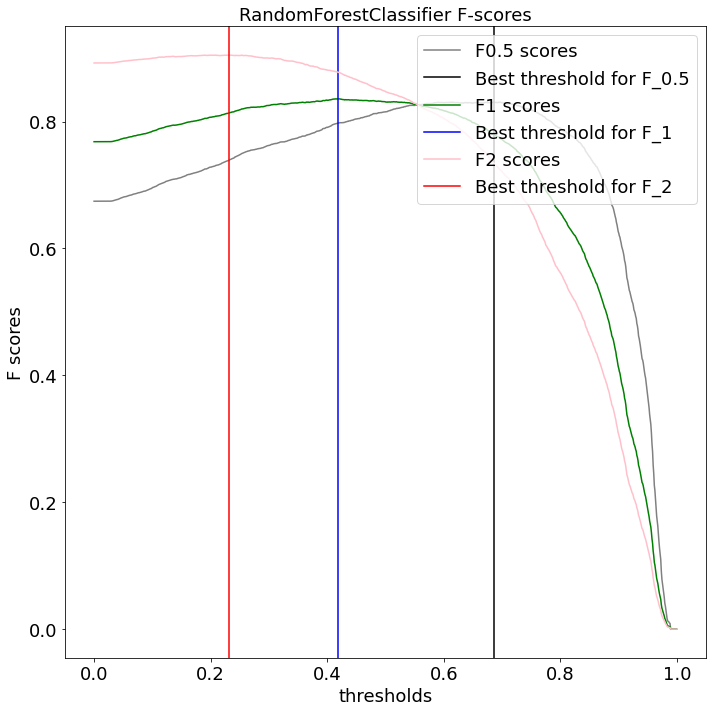

Best Threshold for F_0.5: 0.686453, F_0.5-Score=0.831
Best Threshold for F_1: 0.419612, F_1-Score=0.836
Best Threshold for F_2: 0.234713, F_2-Score=0.905


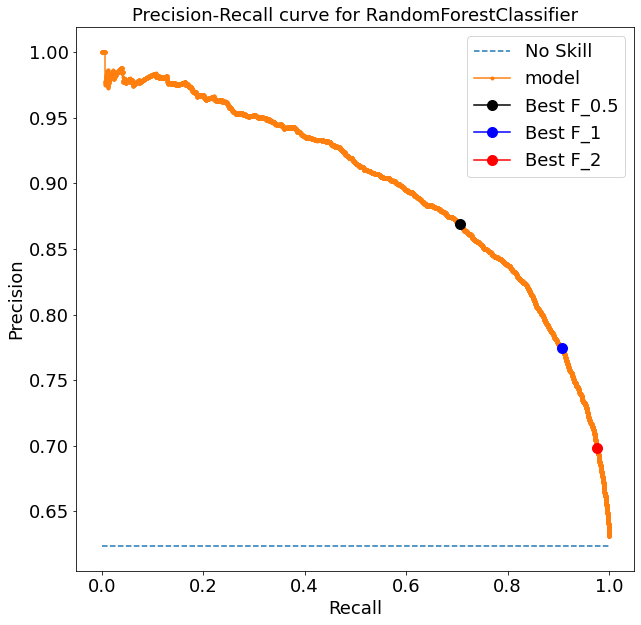

Best Threshold=0.589905, G-Mean=0.772


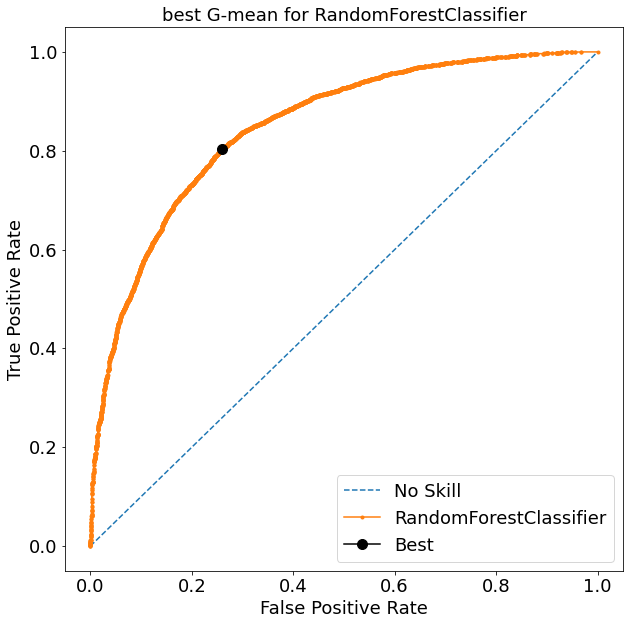

ROC AUC score:  0.8493001203605293
Threshold for  F_0.5 :  0.6864526645129706
Confusion matrix: 
 [[3073  661]
 [1813 4374]]
Classification report:
               precision    recall  f1-score   support

       False       0.63      0.82      0.71      3734
        True       0.87      0.71      0.78      6187

    accuracy                           0.75      9921
   macro avg       0.75      0.76      0.75      9921
weighted avg       0.78      0.75      0.75      9921

Threshold for  F_1 :  0.41961156121972737
Confusion matrix: 
 [[2098 1636]
 [ 571 5616]]
Classification report:
               precision    recall  f1-score   support

       False       0.79      0.56      0.66      3734
        True       0.77      0.91      0.84      6187

    accuracy                           0.78      9921
   macro avg       0.78      0.73      0.75      9921
weighted avg       0.78      0.78      0.77      9921

Threshold for  F_2 :  0.23471303874959468
Confusion matrix: 
 [[1124 2610]
 [ 143 60

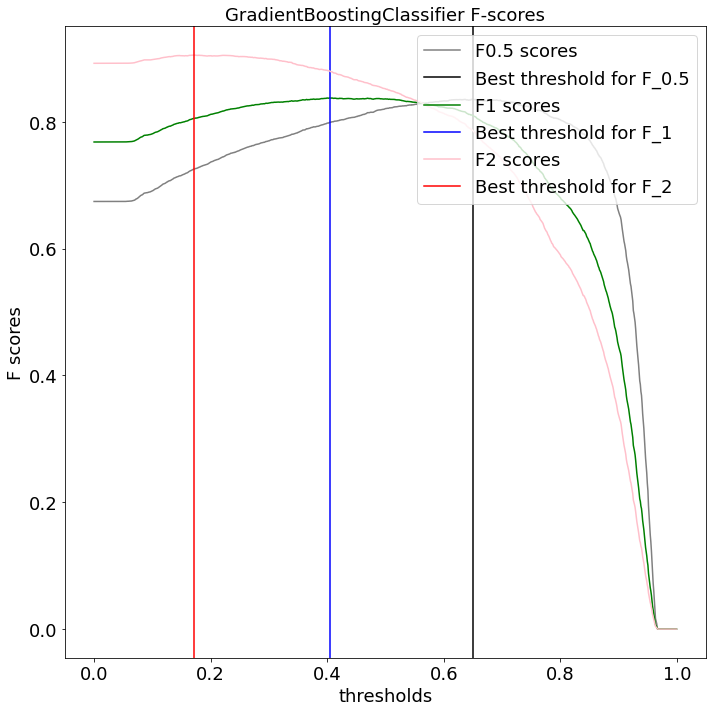

Best Threshold for F_0.5: 0.650740, F_0.5-Score=0.836
Best Threshold for F_1: 0.404515, F_1-Score=0.838
Best Threshold for F_2: 0.169739, F_2-Score=0.905


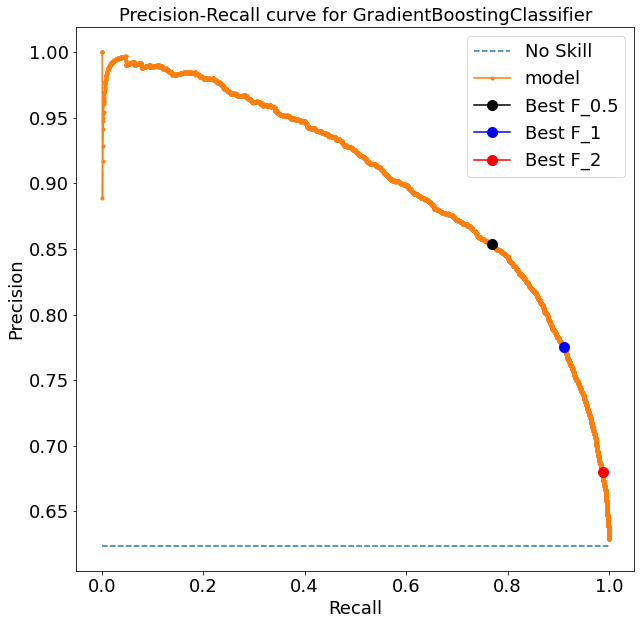

Best Threshold=0.617944, G-Mean=0.777


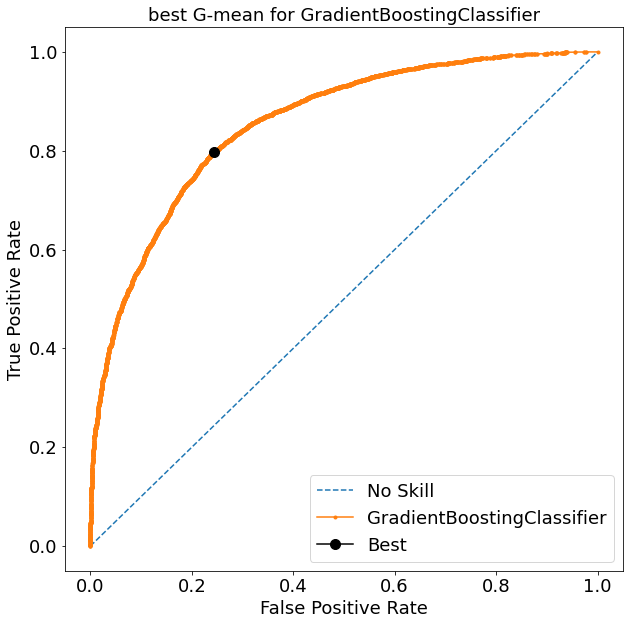

ROC AUC score:  0.8550457492077181
Threshold for  F_0.5 :  0.6507396177019648
Confusion matrix: 
 [[2918  816]
 [1423 4764]]
Classification report:
               precision    recall  f1-score   support

       False       0.67      0.78      0.72      3734
        True       0.85      0.77      0.81      6187

    accuracy                           0.77      9921
   macro avg       0.76      0.78      0.77      9921
weighted avg       0.79      0.77      0.78      9921

Threshold for  F_1 :  0.40451486244340323
Confusion matrix: 
 [[2101 1633]
 [ 551 5636]]
Classification report:
               precision    recall  f1-score   support

       False       0.79      0.56      0.66      3734
        True       0.78      0.91      0.84      6187

    accuracy                           0.78      9921
   macro avg       0.78      0.74      0.75      9921
weighted avg       0.78      0.78      0.77      9921

Threshold for  F_2 :  0.16973938724761511
Confusion matrix: 
 [[ 859 2875]
 [  79 61

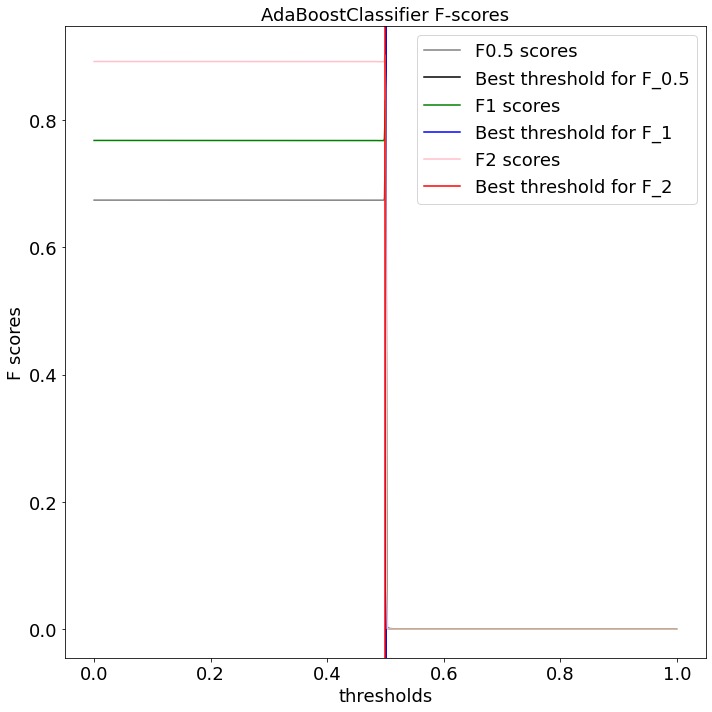

Best Threshold for F_0.5: 0.500335, F_0.5-Score=0.831
Best Threshold for F_1: 0.499923, F_1-Score=0.834
Best Threshold for F_2: 0.499139, F_2-Score=0.904


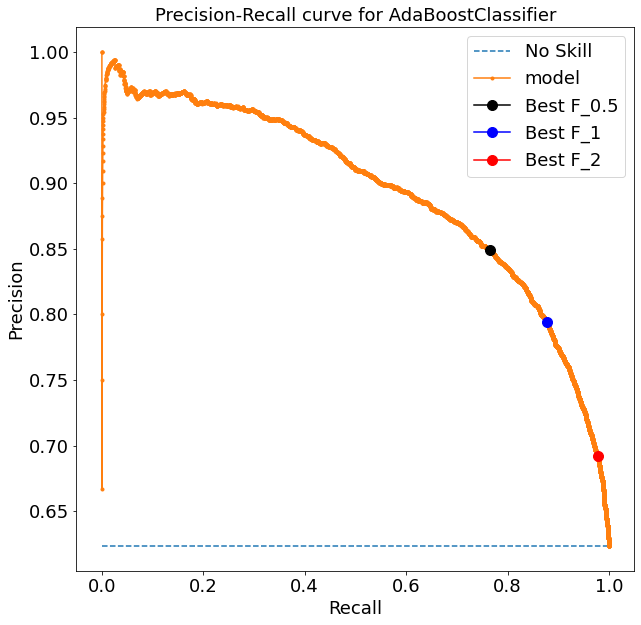

Best Threshold=0.500322, G-Mean=0.770


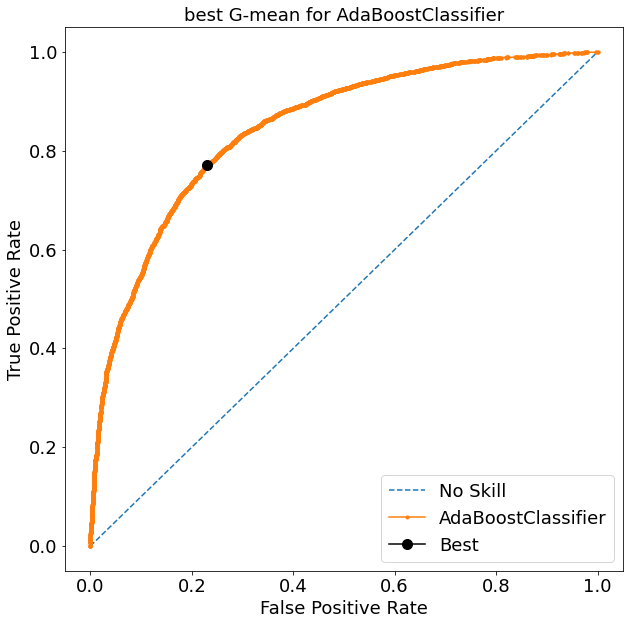

ROC AUC score:  0.8462355930749279
Threshold for  F_0.5 :  0.500335005734593
Confusion matrix: 
 [[2891  843]
 [1447 4740]]
Classification report:
               precision    recall  f1-score   support

       False       0.67      0.77      0.72      3734
        True       0.85      0.77      0.81      6187

    accuracy                           0.77      9921
   macro avg       0.76      0.77      0.76      9921
weighted avg       0.78      0.77      0.77      9921

Threshold for  F_1 :  0.4999227025148297
Confusion matrix: 
 [[2323 1411]
 [ 752 5435]]
Classification report:
               precision    recall  f1-score   support

       False       0.76      0.62      0.68      3734
        True       0.79      0.88      0.83      6187

    accuracy                           0.78      9921
   macro avg       0.77      0.75      0.76      9921
weighted avg       0.78      0.78      0.78      9921

Threshold for  F_2 :  0.499139144601701
Confusion matrix: 
 [[1047 2687]
 [ 136 6051]]

In [36]:
for clf in list(models.values()):
    results(clf)

For churn prediction, emphasis is placed on recall since we do not want to miss any user exhibiting signs of leaving.  This means we use the $F_2$ score as our measure of model effectiveness.  All three ensemble estimators yield an $F_2$ score of 0.905.  We selecte the `GradientBoostingClassifier` estimator with threshold 0.1697 because it gives the highest recall: 99%, with a precision of 68%.

### 3.2. Feature Importance<a id='3.2.'></a>

In [37]:
fi = pd.DataFrame({'features':X.columns,'feature_importance':models['GBC'].feature_importances_})\
    .set_index('features')\
    .sort_values('feature_importance',ascending=False)

In [38]:
fi

,feature_importance
features,
avg_rating_by_driver,0.298231
city_King's Landing,0.152350
surge_pct,0.122026
weekday_pct,0.108846
ultimate_black_user,0.060309
avg_dist,0.055919
trips_in_first_30_days,0.051297
phone_Android,0.042034
phone_iPhone,0.037140


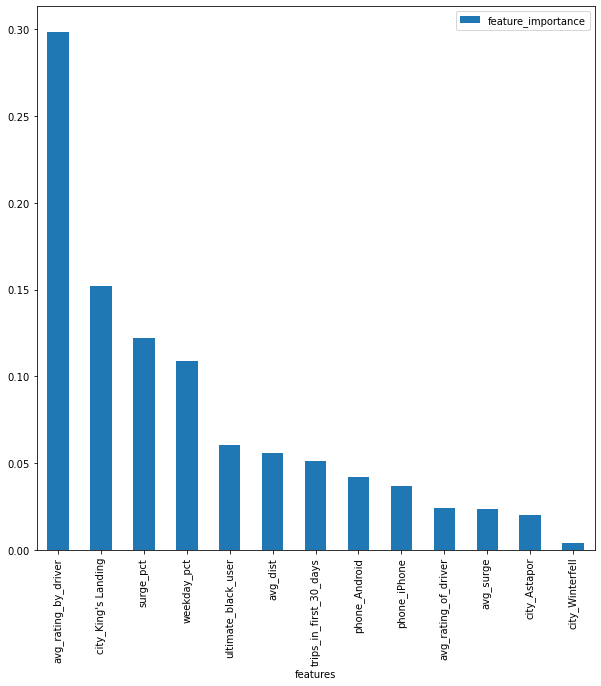

In [39]:
fi.plot(kind='bar')
plt.show()

In [66]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [67]:
lrfi = pd.DataFrame(lr.coef_).T
lrfi.index = X.columns
lrfi.sort_values(0)

,0
trips_in_first_30_days,-11.756422
city_King's Landing,-0.985930
ultimate_black_user,-0.878864
phone_iPhone,-0.554745
surge_pct,-0.334615
weekday_pct,-0.008096
avg_surge,0.007583
city_Winterfell,0.211747
avg_rating_of_driver,0.316180
phone_Android,0.525455


Our above analysis of feature importance shows that, according to the `GradientBoostingClassifier` Estimator, `avg_rating_by_driver` is the most important feature followed by the `city_King'sLanding`, `surge_pct`, and `weekday_pct` variables.  We also do a quick logistic regression to get an idea of the direction of these importances. We see that `avg_rating_by_driver` is directly related to churn--this could be due riders who seldomly ride can have higher ratings.  Also, users more willing to ride during surge pricing and on weekdays are possibly more regular users, hence the negative relation to churn.

## 4. Conculsion<a id='4.'></a>

Ultimate can use this model to preemptively reach out to users showing signs of churn to try to engage them with the ride-share service. From the analysis of feature importance, Ultimate can offer incentives for riding during surge-pricing or on weekdays.  For example, they can earn a free ride/ride credit after a certain number of surge/weekday rides.